Simulate 3body coupling with PA and plot time evolution of wigner function.

In [72]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
import Qsim.operator.spin as spin
import Qsim.operator.phonon as phon
import Qsim.ion_chain.ising.ising_ps as iscp
import Qsim.ion_chain.ising.ising_c as iscc
import Qsim.operator.spin_phonon as sp_op
import Qsim.ion_chain.interaction.spin_phonon as Isp
from  Qsim.ion_chain.ion_system import *
import copy
import imageio
import Qsim.auxiliay_function.wigner as wg
qutip.settings.has_mkl = True  # to avoid OS error in my PC

In [73]:
#%% set ion chain parameters
Nions=3
ion_sys = ions(trap_config={'N': Nions, 'fx': 3.2, 'fz': 1}, 
                   numeric_config={'active_spin': [0, 1, 2],'active_phonon': [[0]], 'pcut': [[40]]},
                   )

Trap coefficients updated
Anharmonic coefficients updated
_____________________________________________________________
Checking phonon space setup
Phonon space setups are consistent
_____________________________________________________________
Phonon space parameters updated
Cooling parameters updated
Trap parametric modulation updated
Ions class object initialized.


In [74]:
#%% set parameters of lasers according to the paper
R1 = 26*1e3*2*np.pi #recoil frequency
#compute Dk
Dk1 = np.sqrt(R1*2*MYb171/h) #effective wavenumber
q = 1.3 #compensation scale parameter
delta = 10 #kHz
laser1 = Laser(config = {'Omega_eff':30,'wavevector':1,'Dk':Dk1,'laser_couple':[0,1,2],
                'mu':2*(delta+1e3*ion_sys.fx),'phase':0})
Omega_r = 10*laser1.eta(ion_sys.fx)
Omega_b = 2*np.sqrt(3)*Omega_r/laser1.eta(ion_sys.fx)
laser1.Omega_eff = Omega_b 
#red sideband
laser2 = copy.copy(laser1)
laser2.Omega_eff = Omega_r 
laser2.mu = -1*(delta+1e3*ion_sys.fx)
#compensation beatnotes
#compensation blue sideband
laser3 = copy.copy(laser1)
laser3.Omega_eff = np.sqrt(q)*Omega_b 
laser3.mu = 2*(-q*delta+1e3*ion_sys.fx)
#compensation red sideband
laser4 = copy.copy(laser1)
laser4.Omega_eff = np.sqrt(q)*Omega_r 
laser4.mu = -1*(-q*delta+1e3*ion_sys.fx)
print('ion_sys.fx = ', ion_sys.fx)
print('________________________________________________')
print('Parameteres of laser 1')
laser1.list_para()
print('________________________________________________')
print('Parameteres of laser 2')
laser2.list_para()
print('________________________________________________')
print('Parameteres of laser 3')
laser3.list_para()
print('________________________________________________')
print('Parameteres of laser 4')
laser4.list_para()
#print(laser1.R/(2*np.pi))
print(Omega_r)
N = Nions

Laser parameters updated
Lasers class object initialized.
ion_sys.fx =  3.2
________________________________________________
Parameteres of laser 1
                                                                 
********************Parameters of Laser Drive************************
Vibrational degree of freedom couples to the laser: Transverse (Radial)
index of ions that couple to the laser field:  [0, 1, 2]
Effective rabi frequency  34.64  [kHz]
Effective laser frequency  6420.0  [kHz]
Laser phase phis 0.0
(input in rad but displayed in degs)
________________________________________________
Parameteres of laser 2
                                                                 
********************Parameters of Laser Drive************************
Vibrational degree of freedom couples to the laser: Transverse (Radial)
index of ions that couple to the laser field:  [0, 1, 2]
Effective rabi frequency  0.9  [kHz]
Effective laser frequency  -3210.0  [kHz]
Laser phase phis 0.0
(input in ra

In [75]:
#%%com mode simulation
def Tthree(eta0, wr,wb,delta0,q):
    J32 = (1+np.sqrt(1/q))*(eta0**4*wr**2*wb)/(16*delta0**2)
    return np.pi/(6*J32)
eta_com = laser1.eta(ion_sys.fx)/np.sqrt(3)
print('predicted period, [ms]')
print(Tthree(eta_com,laser2.Omega(ion_sys),laser1.Omega(ion_sys),delta*2*np.pi,q))

predicted period, [ms]
251.98684663687783


In [83]:
#%% set PA parameters, set V_mod to 0 for dynamics without PA
ion_sys.update_PM(para_mod_config = {'f_mod':2*(ion_sys.fx*1000+delta) ,'V_mod':0*1e-2,'d_T':200})
ion_sys.list_para() #print parameters of the system
gcoef = ion_sys.PA_coef(1,0)/(2*np.pi)
print('g/2pi = ', gcoef ,' [kHz]')
print('Predicted phonon oscillation frequency, [kHz]')
delta1 = np.sqrt(delta**2 - gcoef**2 )
print(delta1)

Trap parametric modulation updated
________________________________________________________________
********************Setup of the Trap************************
number of ions 3
Axial COM (Confining) frequency  1  [MHz]
Radial COM (Confining) frequency  3.2 [MHz]
Axial vibrational eigenfrequency [1.   1.73 2.41] MHz
Radial (Transverse) vibrational eigenfrequency [3.2  3.04 2.8 ] [MHz]
Modulation Amplitude for parameteric amplification:  0.0 [V]
Modulation Frequency for parameteric amplification:  6420.0 [MHz]
Trap dimension parameter:  200 [um]
                                                                 
********************Config of Numeric Calculation************************
index of phonon space included in simulation:  [[0]]
corresonding phonon space cutoff  [[40]]
********************Config of Cooling************************
Effective cooling rate  [2. 2.]  [kHz]
Coolant index  [1]
********************Config of Trap Modulation************************
 Modulation Amplitude 0.

In [94]:
#%% construct states and operators 
#construct initial state (initialized as up up)
spin_config = np.array([1,0,1])
psi1 = sp_op.ini_state(ion_sys,spin_config,[[0,0,0]],1)
#rho1 = sp_op.ini_state(ion_sys,spin_config,[[0,0,0]],0
elist_com = [tensor(spin.sz(N,0),sp_op.p_I(ion_sys)),
          tensor(spin.sz(N,1),sp_op.p_I(ion_sys)),
          tensor(spin.sz(N,2),sp_op.p_I(ion_sys))]
#projection operators
up = basis(2,0)
down = basis(2,1)
s1 = (basis(2,0)+basis(2,1))/np.sqrt(2) #+
s2 = (basis(2,0)-basis(2,1))/np.sqrt(2) #-
sup = tensor(up,up,up); sdown = tensor(down,down,down)
splus = tensor(s1,s1,s1) ; sminus = tensor(s2,s2,s2)
proj1=tensor(splus*splus.dag(),sp_op.p_I(ion_sys)) #|+++>
proj2=tensor(sminus*sminus.dag(),sp_op.p_I(ion_sys)) #|--->
proj3 = tensor(sup*sup.dag(),sp_op.p_I(ion_sys))
proj4 = tensor(sdown*sdown.dag(),sp_op.p_I(ion_sys))

In [95]:
#%%construct Hamiltonian 
Htb_com, arg_tb = iscc.H_com_multi(ion_sys,laser2,laser1,laser4,laser3,q) #construct time-dependent H
H_PA_com, arg_Hpa = Isp.H_PA_td(ion_sys)
Heff_com = Htb_com + H_PA_com; arg_com = arg_tb | arg_Hpa
#solve time dependent SE
times =  np.arange(0,500,1e-3)
#solve time dependent SE
print('______________________________________________________________________')
print('solving for complete Hamiltonian')
result2 = sesolve(Heff_com,psi1,times,args = arg_com,progress_bar=True,options=Options(nsteps=10000))     
#result2 = mesolve(Heff2,rho1,times,args = arg2,progress_bar=True,options=Options(nsteps=10000))  

______________________________________________________________________
solving for complete Hamiltonian
10.0%. Run time:  15.51s. Est. time left: 00:00:02:19
20.0%. Run time:  30.65s. Est. time left: 00:00:02:02
30.0%. Run time:  46.08s. Est. time left: 00:00:01:47
40.0%. Run time:  61.25s. Est. time left: 00:00:01:31
50.0%. Run time:  76.45s. Est. time left: 00:00:01:16
60.0%. Run time:  91.65s. Est. time left: 00:00:01:01
70.0%. Run time: 107.32s. Est. time left: 00:00:00:45
80.0%. Run time: 122.51s. Est. time left: 00:00:00:30
90.0%. Run time: 137.77s. Est. time left: 00:00:00:15
Total run time: 153.50s


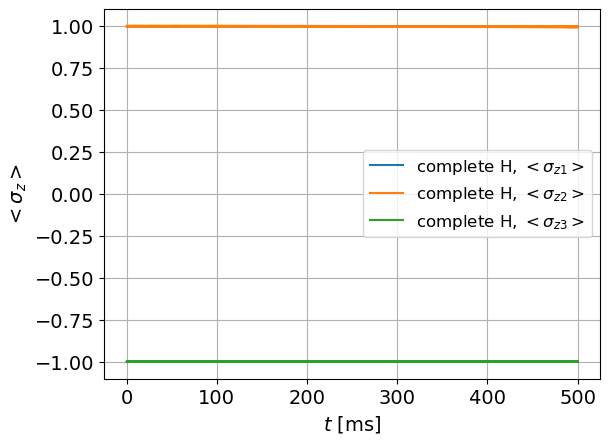

In [96]:
#%%plot spin evolution
p=[]
for i in range(3): p.append(expect(elist_com[i],result2.states))
#p3 = expect(elist_com[1],result2.states)
#p2 = expect(sum(elist_com),result2.states)

for i in range(3): plt.plot(times,p[i],label = r'complete H, $<\sigma_{z'+str(i+1)+'}>$')
#plt.plot(times,p3,label = 'complete H')

plt.xlabel(r'$t$ [ms]',fontsize = 14)
#title = r'$\delta_{com} = $'+str(ion_sys.delta)+' kHz'
plt.ylabel(r'$<\sigma_{z}>$',fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

Maximum phonon population highest com fock state
0.00047125793725014413


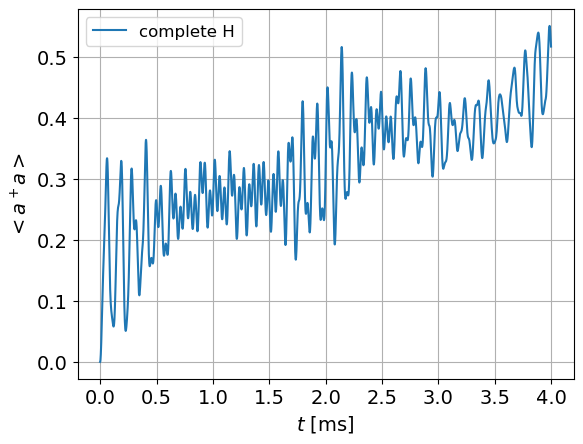

In [26]:
#%% plot phonon evolution
mp_state1 = expect(sp_op.pstate_measure(ion_sys,laser1,39,0),result2.states) 
pplot = expect(sp_op.phonon_measure(ion_sys,laser1, mindex=0), result2.states)
print('Maximum phonon population highest com fock state')
print(np.max(mp_state1))  
plt.plot(times,pplot,label= 'complete H')
plt.xlabel(r'$t$ [ms]',fontsize = 14)
plt.ylabel(r'$<a^+ a>$',fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.legend(fontsize = 12)
plt.grid()
plt.show()

In [16]:
#%% generate frames for gif, use |---> as projector
tot_frame = 500
wg.wigner_evol_frames(tot_frame,times,result2, proj2, 3)

start frame generation
percent of tasks completed: 10%
percent of tasks completed: 20%
percent of tasks completed: 30%
percent of tasks completed: 40%
percent of tasks completed: 50%
percent of tasks completed: 60%
percent of tasks completed: 70%
percent of tasks completed: 80%
percent of tasks completed: 90%
All tasks finished.


In [17]:
#%% create gif using generated frames
output_name = '3body pa-4ms-0.06V-d5kH.gif'
wg.wiger_evol_gif(tot_frame, output_name, frame_duration=0.25, remove_frame = True)

3body pa-10 ms-0.06V-d10kH.gif successfully generated.
Stored at /Users/guidopagano/Google Drive local/My Papers/Three-body+modulation/Ipython notebook
